RandomForestClassifier/XGBClassifier/MLPClassifier with Shap

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

import shap
from xgboost import XGBClassifier, DMatrix
from matplotlib.colors import LinearSegmentedColormap

from sklearn.neural_network import MLPClassifier
import json

C:\Users\Beebie\AppData\Local\Temp\ipykernel_1896\1417274298.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\Beebie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load datasets
df_train = pd.read_json('dataset/train_dataset.json')
df_val = pd.read_json('dataset/validation_dataset.json')
df_test = pd.read_json('dataset/test_dataset.json')

In [3]:
# Categories
categories = [
    'Generic policy', 'Reporting mechanism', 'Information on maintainer', 
    'Scope of practice', 'Projects practice', 'History of vulnerability', 
    'User guideline', 'Additional information',
]

for category in categories:
    df_train[category] = df_train['SecurityPolicy_content_category'].apply(lambda x: 1 if category in x else 0)
    df_val[category] = df_val['SecurityPolicy_content_category'].apply(lambda x: 1 if category in x else 0)
    df_test[category] = df_test['SecurityPolicy_content_category'].apply(lambda x: 1 if category in x else 0)

# Features
selected_features = ['num_commits', 'project_age_days', 'num_contributors', 
                     'num_issues', 'num_pull', 'num_opening_issue', 'project_size(kB)', 
                     'num_stargazers', 'num_watchers', 'num_forks', 'num_subscribers']

# Change category to be trained here
X_train, y_train = df_train[selected_features], df_train['Generic policy']
X_val, y_val = df_val[selected_features], df_val['Generic policy']
X_test, y_test = df_test[selected_features], df_test['Generic policy']

In [4]:
# Encode target variables
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

Random forest Classification

In [5]:
# Train Random forest
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

# Validate RF
y_val_pred = rf_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')
print('Validation Report:')
print(classification_report(y_val, y_val_pred))

# Test RF
y_test_pred = rf_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')
print('Test Report:')
print(classification_report(y_test, y_test_pred))


Validation Accuracy: 0.68
Validation Report:
              precision    recall  f1-score   support

           0       0.50      0.16      0.24        19
           1       0.70      0.93      0.80        41

    accuracy                           0.68        60
   macro avg       0.60      0.54      0.52        60
weighted avg       0.64      0.68      0.62        60

Test Accuracy: 0.65
Test Report:
              precision    recall  f1-score   support

           0       0.33      0.10      0.15        10
           1       0.68      0.90      0.78        21

    accuracy                           0.65        31
   macro avg       0.51      0.50      0.46        31
weighted avg       0.57      0.65      0.57        31



100%|██████████| 31/31 [00:03<00:00,  8.65it/s]


Text(0.5, 32.10000000000005, 'SHAP value')

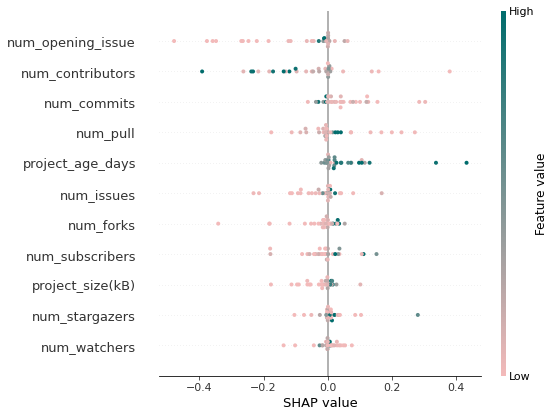

In [6]:
# Shap RF
explainer = shap.KernelExplainer(rf_clf.predict, shap.kmeans(X_train, 10))
shap_values = explainer.shap_values(X_test)

cmap = LinearSegmentedColormap.from_list("custom", ["#f3baba", "#006C6C"])
shap.summary_plot(shap_values, X_test, cmap=cmap, show=False)
# plt.title("Generic policy", fontsize=20)
plt.xlabel("SHAP value")

XGBoost Classification

In [7]:
xg_clf = XGBClassifier()
xg_clf.fit(X_train, y_train)

# Validate XGB
y_val_pred = xg_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')
print('Validation Report:')
print(classification_report(y_val, y_val_pred))

# Test XGB
y_test_pred = xg_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')
print('Test Report:')
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 0.68
Validation Report:
              precision    recall  f1-score   support

           0       0.50      0.26      0.34        19
           1       0.72      0.88      0.79        41

    accuracy                           0.68        60
   macro avg       0.61      0.57      0.57        60
weighted avg       0.65      0.68      0.65        60

Test Accuracy: 0.68
Test Report:
              precision    recall  f1-score   support

           0       0.50      0.40      0.44        10
           1       0.74      0.81      0.77        21

    accuracy                           0.68        31
   macro avg       0.62      0.60      0.61        31
weighted avg       0.66      0.68      0.67        31



Text(0.5, 32.10000000000005, 'SHAP value')

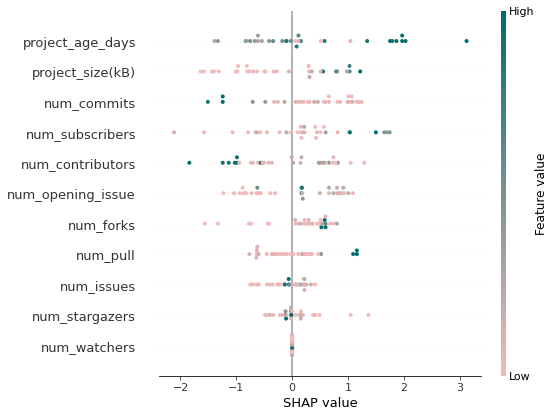

In [8]:
# Shap XGB
explainer = shap.TreeExplainer(xg_clf)
shap_values = explainer.shap_values(X_test)

cmap = LinearSegmentedColormap.from_list("custom", ["#f3baba", "#006C6C"])
shap.summary_plot(shap_values, X_test, cmap=cmap, show=False)
# plt.title("Generic policy", fontsize=20)
plt.xlabel("SHAP value")

NN MLPClassifier

In [9]:
mlp_clf = MLPClassifier()
mlp_clf.fit(X_train, y_train)

# Validate RF
y_val_pred = mlp_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')
print('Validation Report:')
print(classification_report(y_val, y_val_pred))

# Test RF
y_test_pred = mlp_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')
print('Test Report:')
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 0.45
Validation Report:
              precision    recall  f1-score   support

           0       0.23      0.32      0.27        19
           1       0.62      0.51      0.56        41

    accuracy                           0.45        60
   macro avg       0.42      0.41      0.41        60
weighted avg       0.50      0.45      0.47        60

Test Accuracy: 0.32
Test Report:
              precision    recall  f1-score   support

           0       0.26      0.60      0.36        10
           1       0.50      0.19      0.28        21

    accuracy                           0.32        31
   macro avg       0.38      0.40      0.32        31
weighted avg       0.42      0.32      0.30        31

